In [1]:
import numpy as np
import matplotlib.pyplot as plt
import omnical.info as oi
import omnical.arrayinfo as oai
%matplotlib notebook

In [2]:
Separation = 14.6
hexNum = 11
SplitCore = True
#SplitCoreOutriggers = 4
SplitCoreOutriggers = 0
CutDownTo = 242
SpreadOut128 = False
precisionFactor = 1000 

In [3]:
#Main Hex
right = Separation*np.asarray([1,0,0])
up = Separation*np.asarray([0,1,0])
upRight = Separation*np.asarray([.5,3**.5/2,0])
upLeft = Separation*np.asarray([-.5,3**.5/2,0])

positions = [];
for row in range(-(hexNum)+SplitCore+1,hexNum):
    for col in range(0,2*hexNum-abs(row)-1):
        xPos = ((-(2*hexNum-abs(row))+2)/2.0 + col)*Separation;
        yPos = row*Separation*3**.5/2;
        positions.append([xPos, yPos, 0])

In [4]:
#Split the core into 3 pieces
if SplitCore:
    newPos = []
    for i,pos in enumerate(positions):          
        theta = np.arctan2(pos[1],pos[0])
        if (pos[0]==0 and pos[1]==0):
            newPos.append(pos)
        elif (theta > -np.pi/3 and theta < np.pi/3):
            newPos.append(np.asarray(pos) + (upRight + upLeft)/3)                    
        elif (theta >= np.pi/3 and theta < np.pi):
            newPos.append(np.asarray(pos) +upLeft  - (upRight + upLeft)/3)
        else:
            newPos.append(pos)
    positions = newPos

In [5]:
if SplitCoreOutriggers > 0:
    exteriorHexNum = SplitCoreOutriggers
    for row in range(exteriorHexNum-1,-(exteriorHexNum),-1):
        for col in range(2*exteriorHexNum-abs(row)-1):
            xPos = ((-(2*exteriorHexNum-abs(row))+2)/2.0 + col)*Separation*(hexNum-1)
            yPos = row*Separation*(hexNum-1)*3**.5/2
            theta = np.arctan2(yPos,xPos)       
            if ((xPos**2 + yPos**2)**.5 > Separation*(hexNum+1)):
                if (theta > 0 and theta <= 2*np.pi/3+.01):
                    positions.append(np.asarray([xPos, yPos, 0]) - 4*(upRight + upLeft)/3)
                elif (theta <= 0 and theta > -2*np.pi/3):
                    positions.append(np.asarray([xPos, yPos, 0])- 2*(upRight + upLeft)/3)
                else:
                    positions.append(np.asarray([xPos, yPos, 0]) - 3*(upRight + upLeft)/3)

In [6]:
print len(positions)
if False:
    np.savetxt('/Users/jsdillon/Desktop/HERA_350_Positions.txt',positions)

320


<IPython.core.display.Javascript object>


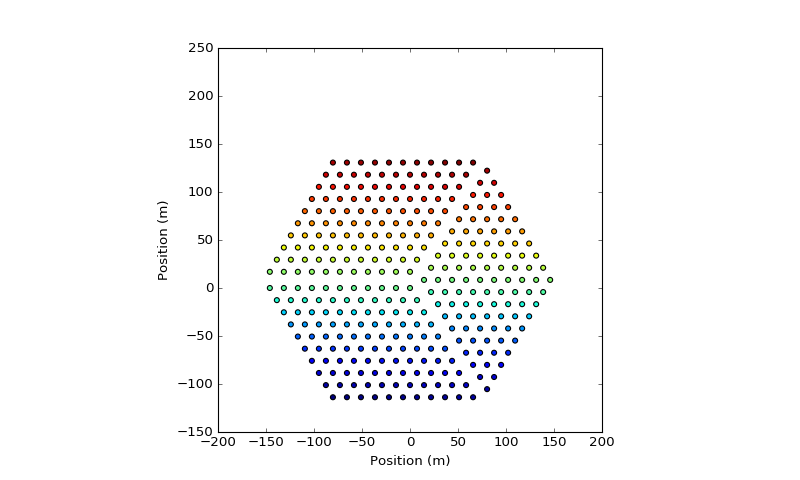

In [7]:
plt.figure(1, figsize=(10,6)); plt.clf()
plt.scatter(np.asarray(positions)[:,0],np.asarray(positions)[:,1], c = range(len(positions)))
plt.xlabel('Position (m)'); plt.ylabel('Position (m)');
plt.axis('square');

# Calculate Baselines

In [8]:
baselineDict = {}
for ant1 in range(len(positions)):
    for ant2 in range(ant1+1,len(positions)):
        baseline = tuple([int(np.round(precisionFactor*(positions[ant1][i]-positions[ant2][i]))) for i in range(3)])
        if baselineDict.has_key(baseline): baselineDict[baseline] += 1
        else: baselineDict[baseline] = 1

uniqueBaselines = np.asarray(baselineDict.keys())/(1.0*precisionFactor)
redundancy = np.asarray(baselineDict.values())
print "With", len(positions), "antennas there are", len(uniqueBaselines), "unique baselines."
uniqueBaselines = np.append(uniqueBaselines, -uniqueBaselines, axis=0)
redundancy = np.append(redundancy, redundancy, axis=0)
uniqueBaselines = uniqueBaselines[np.argsort(redundancy)]
redundancy = redundancy[np.argsort(redundancy)]

With 320 antennas there are 1501 unique baselines.


<IPython.core.display.Javascript object>


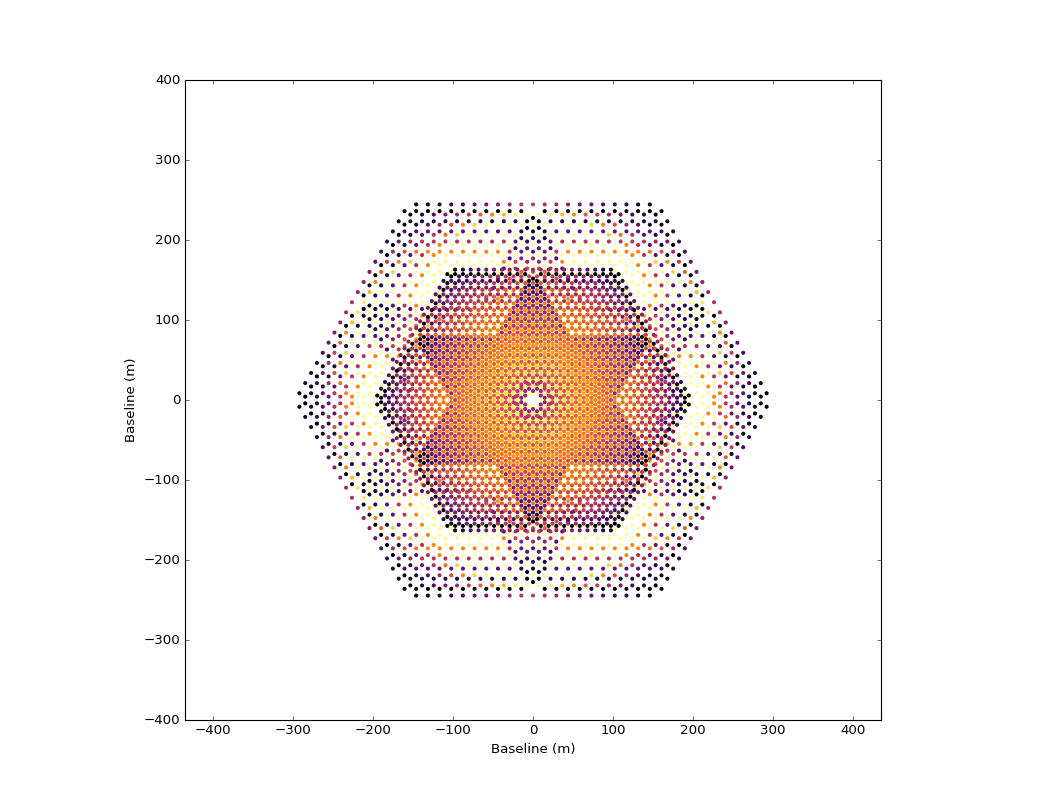

In [10]:
plt.figure(2, figsize=(13,10)); plt.clf()
plt.scatter(uniqueBaselines[:,0]/1.0, uniqueBaselines[:,1]/1.0,s=7,c=(np.minimum(redundancy,20)),cmap='inferno',edgecolors='face')
plt.scatter(uniqueBaselines[:,0]/1.0/1.5, uniqueBaselines[:,1]/1.0/1.5,s=7,c=np.log10(redundancy),cmap='inferno',edgecolors='face')
#plt.scatter(uniqueBaselines[:,0]/1.0, uniqueBaselines[:,1]/1.0,c=np.minimum(redundancy,2),s=30)
plt.xlabel('Baseline (m)'); plt.ylabel('Baseline (m)')
#plt.title('log10(redundancy)')

plt.axis('square')
plt.xlim(-435,435); plt.ylim(-400,400);

# Is the array Omnical-able?

In [23]:
redundantInfo = oi.RedundantInfo()
positions = np.asarray(positions)
reds = oai.compute_reds(positions)
redundantInfo.init_from_reds(reds, positions)

AtransA = redundantInfo.At.dot(redundantInfo.At.T).toarray()
BtransB = redundantInfo.Bt.dot(redundantInfo.Bt.T).toarray()    
gainVariances = np.diag(np.linalg.pinv(AtransA)[0:len(positions),0:len(positions)])
degenerateModes = [len(XtransX) - np.linalg.matrix_rank(XtransX, tol=1e-10) for XtransX in [AtransA, BtransB]]
if degenerateModes == [1,3]: print 'Yes.'
else: print 'No.', degenerateModes

Yes.


<IPython.core.display.Javascript object>


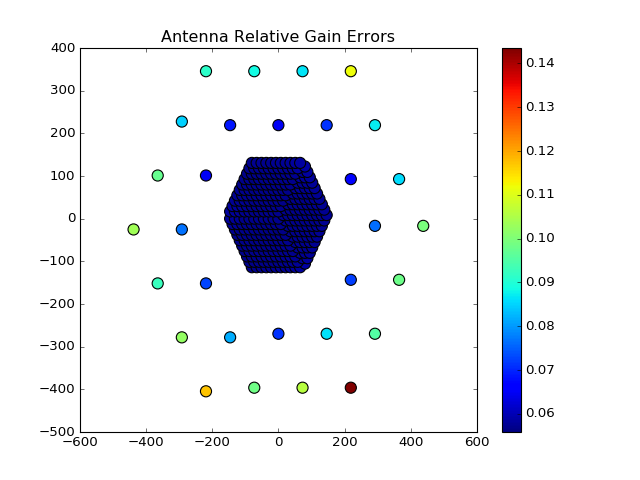

In [24]:
plt.figure(10)
hexScatter = plt.scatter(positions[:,0], positions[:,1], c=np.sqrt(gainVariances), s=100)
plt.colorbar()
plt.title('Antenna Relative Gain Errors')